**Author:** Jhosimar George Arias Figueroa

In [1]:
require "nn"
require "nngraph"
require "optim"
require "KLD_Gaussian_Criterion"
require "image"

### Load MNIST images 

In [2]:
mnist = require "mnist"

In [3]:
train_data = mnist.traindataset().data:double():div(255) -- normalised [0, 1]
n_samples = mnist.traindataset().size
m_features = mnist.traindataset().data:size(2) * mnist.traindataset().data:size(3)
print("Number of Samples: ".. n_samples .. ". Feature Dimension: ".. m_features)

Number of Samples: 60000. Feature Dimension: 784	


### Data Visualization

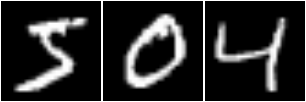

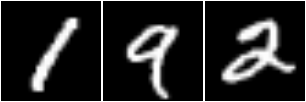

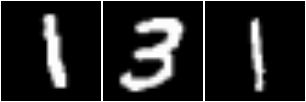

In [4]:
scale = 100
for i=1,9,3 do
    itorch.image({image.scale(train_data[i],scale), 
                  image.scale(train_data[i+1],scale), 
                  image.scale(train_data[i+2],scale)})
end

### Variational Autoencoder
Variational Autoencoder consist of an encoder, a decoder and a loss function.

#### Encoder
Encoder network receives as input the image representation, in case of MNIST dataset it is a 28x28 pixel image.
The encoder *‘encodes’* the data which is 784-dimensional into a latent (hidden) representation space z, which is much less than 784 dimensions. 

In our class, the encoder calculates the mean and standard deviation of the gaussian which will produce the latent variable z.

#### Decoder
Decoder network receives as input the latent variable z. The decoder *‘decodes’* the real-valued numbers in z into 784 real-valued numbers between 0 and 1. Information is lost because it goes from a smaller to a larger dimensionality.

#### Loss function
The loss function of the variational autoencoder is the negative log-likelihood with a regularizer.
\begin{align}
L^{\tt{v}} & = \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) - D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)&\\
\end{align}

The first term is the reconstruction loss, or expected negative log-likelihood of the i-th datapoint. This term encourages the decoder to learn to reconstruct the data. If the decoder’s output does not reconstruct the data well, it will incur a large cost in this loss function.

The second term is a regularizer. This is the Kullback-Leibler divergence between the encoder’s distribution q(z∣x) and p(z). This divergence measures how much information is lost when using q to represent p. It is one measure of how close q is to p.

In [5]:
-- Resize data into 1D
train_data = train_data:resize(train_data:size(1), train_data:size(2)*train_data:size(3))

In [6]:
do
    local VAE = torch.class("VariationalAutoencoder")
    local BCE_criteria
    local KLD_criteria
    
    -- VAE initialization
    function VAE:__init(latent_dim)
        BCE_criteria = nn.BCECriterion()
        BCE_criteria.sizeAverage = false
        KLD_criteria = nn.KLD_Gaussian_Criterion()
        self.latent_dim = latent_dim
    end
    
     -- Build a VAE from data X ( num_samples x num_features ) 
    function VAE:fit(X)
        self.num_samples = X:size(1)
        self.num_features = X:size(2)
        self.data = X
    end
    
    -- Encoder network
    -- params: number of features, latent space dimension
    -- input: data (num_samples x num_features )
    -- output: mean and logarithm of variance
    function get_encoder(num_features, latent_dim)
        local input = - nn.Identity()
        
        local hidden_layer = input 
                    - nn.Linear(num_features, 400) - nn.ReLU(true) -- - nn.Tanh()
                    - nn.Linear(400,200) - nn.ReLU(true) -- - nn.Tanh()
        local W_mean = hidden_layer - nn.Linear(200, latent_dim)
        local W_logVar = hidden_layer - nn.Linear(200, latent_dim)

        local z_latent = {W_mean, W_logVar} - nn.Identity()

        return nn.gModule({input}, {z_latent})
    end
    
    -- Decoder network
    -- params: number of features, latent space dimension
    -- input: representation z obtained after reparametrization trick
    -- output: reconstruction of initial data X
    function get_decoder(num_features, latent_dim)
        local input = - nn.Identity()

        local generated = input
                    - nn.Linear(latent_dim, 200)  - nn.ReLU(true) -- - nn.Tanh()
                    - nn.Linear(200, 400) - nn.ReLU(true) -- - nn.Tanh()
                    - nn.Linear(400, num_features) - nn.Sigmoid()

        return nn.gModule({input} , {generated})
    end
    
    -- Gaussian sampler
    -- params: latent space dimension
    -- input: mean, logarithm of variance from encoder and noise
    -- output: gaussian sample based on reparametrization trick
    function gaussian_sampler(latent_dim)

        local z_latent = - nn.Identity()
        local noise = - nn.Identity() 
        
        local mean = z_latent - nn.SelectTable(1)
        local logVar = z_latent - nn.SelectTable(2)
                      
        local sigma = logVar 
                            - nn.MulConstant(0.5) -- Compute 1/2 log σ^2 = log σ
                            - nn.Exp() -- Compute σ
        
        local sigma_noise = {sigma, noise} - nn.CMulTable() -- Compute σε
        
        -- Reparametrization trick 
        -- N(z; μ, σI) = μ + σε
        local sample = {mean, sigma_noise} - nn.CAddTable() - nn.View(-1, latent_dim)
        
        return nn.gModule({z_latent, noise}, {sample})
    end
    
    -- VAE model
    -- input: data and noise
    -- output: reconstructed data, mean and logarithm of variance
    function get_vae_model(self, num_features, latent_dim)
        local input_data = - nn.Identity()
        local input_noise = - nn.Identity()
        
        --Encoder: Calculate mean and std from input data
        local encoder = input_data - get_encoder(num_features, latent_dim)
        
        --Sampler: Reparametrization trick - add gaussian noise
        local z_sample = {encoder, input_noise} - gaussian_sampler(latent_dim)

        --Decoder: Reconstruct data from latent sample z
        self.decoder = get_decoder(num_features, latent_dim) -- used later for generation
        local reconstruct = z_sample - self.decoder
        
        return nn.gModule({input_data, input_noise} , {reconstruct, encoder})
    end
    
    --Function used in optim module for optimization
    --Return loss obtained after forward and gradients after backward
    function feval(x)

        if x ~= params then
            params:copy(x)
        end

        VAE_model:zeroGradParameters()
        
        local reconstructed, z_latent = table.unpack( VAE_model:forward({batch_data, batch_noise}) )

        -- 1.) Reconstruction Cost = E[logP(y|x)] 
        -- Binary Cross entropy because we have binary values(0,1)
        local reconstruction_loss = BCE_criteria:forward(reconstructed , batch_data)
        local reconstruction_grad = BCE_criteria:backward(reconstructed , batch_data)

        -- 2.) KL-divergence cost = KL(Q(z|x) || P(z)) P(z)~gaussian
        local regularization_loss = KLD_criteria:forward(z_latent)
        local regularization_grad = KLD_criteria:backward(z_latent)

        local gradLoss = {reconstruction_grad, regularization_grad}
        VAE_model:backward({batch_data, batch_noise}, gradLoss)
        
        -- Loss = Reconstruction loss + KL-divergence cost
        local loss = reconstruction_loss + regularization_loss

        return loss, gradParams
        
    end
    
    -- Train VAE
    function VAE:train(batch_size, epochs, learning_rate, optimiser)
        
        VAE_model = get_vae_model(self,self.num_features, self.latent_dim)
        params, gradParams = VAE_model:getParameters()
    
        -- Save loss per epoch
        self.losses = {}
        
        -- Number of iterations
        for epoch = 1,epochs do
            
            --Sample noise ε ~ N(0, 1)
            local gaussian_noise = torch.randn(self.num_samples, self.latent_dim) 
            local indices_all = torch.randperm(self.num_samples):long()
            local indices = indices_all:split(batch_size)
            local Loss = 0.0
            
            -- Training in batches
            for t,v in ipairs(indices) do
                xlua.progress(t, #indices)
                batch_data = self.data:index(1, v)
                batch_noise = gaussian_noise:index(1,v)
                __, loss = optim[optimiser](feval, params, {learningRate = learning_rate })
                Loss = Loss + loss[1]
            end
            
            print("Epoch: " .. epoch .. " Loss: " .. Loss/batch_size )
            self.losses[#self.losses + 1] = Loss
        end
    end
    
    -- Generate random data after training
    function VAE:generate()
        local noise = torch.randn(self.latent_dim):double()
        return self.decoder:forward(noise)
    end
    
    -- Reconstruct data
    -- input: data with dimensions (1 x num_features)
    -- output: reconstructed data (1 x num_features)
    function VAE:reconstruct(x)
        local noise = torch.randn(self.latent_dim):double()
        local reconstructed, z_latent = table.unpack(VAE_model:forward({x, noise}))
        return reconstructed
    end
    
end


### Testing Variational Autoencoder

In [7]:
-- VAE Instantiation
VAE = VariationalAutoencoder(20)

-- Use MNIST dataset
VAE:fit(train_data)

--VAE:generate()
-- Train VAE (batch_size, epochs, learning_rate, optimizer)
VAE:train(100, 20, 0.0001, "adam")

 [=====================================================================================>]                                Tot: 2m12s | Step: 221ms 

Epoch: 1 Loss: 139075.07651604	


 [=====================================================================================>]                                Tot: 2m12s | Step: 223ms 

Epoch: 2 Loss: 110235.16615668	


 [=====================================================================================>]                                Tot: 2m16s | Step: 229ms 

Epoch: 3 Loss: 98869.396576357	


 [=====================================================================================>]                                Tot: 2m12s | Step: 223ms 

Epoch: 4 Loss: 92765.902867028	


 [=====================================================================================>]                                Tot: 2m8s | Step: 215ms 

Epoch: 5 Loss: 88923.598381069	


 [=====================================================================================>]                                Tot: 2m6s | Step: 212ms 

Epoch: 6 Loss: 85725.552377524	


 [=====================================================================================>]                                Tot: 2m4s | Step: 210ms 

Epoch: 7 Loss: 83256.456797647	


 [=====================================================================================>]                                Tot: 2m8s | Step: 216ms 

Epoch: 8 Loss: 81270.528814717	


 [=====================================================================================>]                                Tot: 2m12s | Step: 222ms 

Epoch: 9 Loss: 79710.150835261	


 [=====================================================================================>]                                Tot: 2m12s | Step: 223ms 

Epoch: 10 Loss: 78394.11899518	


 [=====================================================================================>]                                Tot: 2m18s | Step: 233ms 

Epoch: 11 Loss: 77284.88615	


 [=====================================================================================>]                                Tot: 2m24s | Step: 242ms 

Epoch: 12 Loss: 76376.161395969	


 [=====================================================================================>]                                Tot: 2m30s | Step: 252ms 

Epoch: 13 Loss: 75629.532381622	


 [=====================================================================================>]                                Tot: 2m24s | Step: 243ms 

Epoch: 14 Loss: 74995.961981034	


 [=====================================================================================>]                                Tot: 2m12s | Step: 222ms 

Epoch: 15 Loss: 74405.079902333	


 [=====================================================================================>]                                Tot: 2m5s | Step: 210ms 

Epoch: 16 Loss: 73912.460915408	


 [=====================================================================================>]                                Tot: 2m10s | Step: 219ms 

Epoch: 17 Loss: 73464.04338388	


 [=====================================================================================>]                                Tot: 2m7s | Step: 215ms 

Epoch: 18 Loss: 73064.987214809	


 [=====================================================================================>]                                Tot: 2m11s | Step: 220ms 

Epoch: 19 Loss: 72706.798235085	


 [=====================================================================================>]                                Tot: 2m12s | Step: 222ms 

Epoch: 20 Loss: 72378.947744387	


#### Plot - Epoch vs Loss

In [8]:
Plot = require 'itorch.Plot'
losses = VAE.losses
x = torch.linspace(-1, #losses + 1, #losses)
y = torch.DoubleTensor(losses)
plot = Plot():line(x, y,'blue','loss'):legend(true):title('Training Loss'):xaxis('epoch #'):yaxis('loss'):draw()

#### Reconstruction Test

Visualize reconstruction from MNIST test images

In [9]:
-- Visualize reconstruction from MNIST test images
test_data = mnist.testdataset().data:double():div(255) -- normalised [0, 1]
test_data = test_data:resize(test_data:size(1), test_data:size(2)*test_data:size(3)) -- resize data into 1D

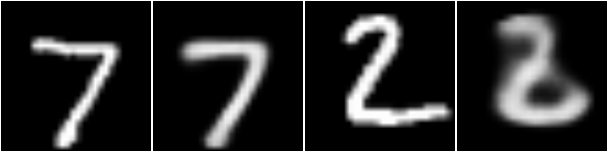

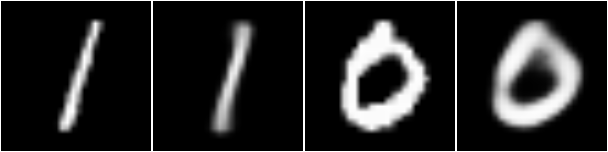

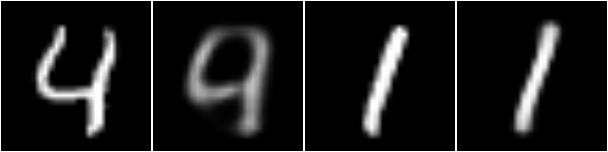

In [10]:
scale = 150
for i=1,6,2 do
    reconstructed_left = VAE:reconstruct(test_data[i]):clone()
    reconstructed_right = VAE:reconstruct(test_data[i+1]):clone()
    itorch.image({
            image.scale(test_data[i]:resize(28,28),scale), image.scale(reconstructed_left:resize(28,28),scale),
            image.scale(test_data[i+1]:resize(28,28),scale),image.scale(reconstructed_right:resize(28,28),scale)
    })
end

#### Random Generation Test

Visualize random generation for MNIST

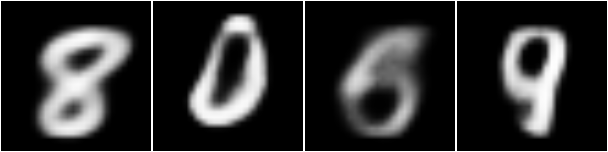

In [11]:
image_table = {}
for i = 1, 4 do
    image_table[i] = image.scale(VAE:generate():resize(28,28),scale)
end
itorch.image(image_table)